In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram
import glob
from decimal import Decimal
from eofs.xarray import Eof

In [2]:
plt.style.use('ggplot')

In [20]:
reso = [0.01,0.02,0.025,0.03,0.04,0.05,0.1]
c = 10
deltaS = reso[1]
deltaT = c*deltaS
sbins = np.arange(30,40, deltaS) 
tbins = np.arange(-2, 33, deltaT)
region='global'

In [3]:
# -- Read histNat
dirhistNat = '/data/ysilvy/CMIP5_annual/4D/'
dsT_hn = xr.open_dataset(dirhistNat+'thetao_Oyr_IPSL-CM5A-LR_historicalNat_r2i1p1_185001-201212.nc')
dsS_hn = xr.open_dataset(dirhistNat+'so_Oyr_IPSL-CM5A-LR_historicalNat_r2i1p1_185001-201212.nc')
dirvolhn = '/bdd/CMIP5/output/IPSL/IPSL-CM5A-LR/historicalNat/fx/ocean/fx/r0i0p0/latest/volcello/'
dsvol_hn = xr.open_dataset(dirvolhn+'volcello_fx_IPSL-CM5A-LR_historicalNat_r0i0p0.nc')

In [11]:
dsvol_hn = dsvol_hn.reindex(lev=list(dsT_hn.lev))
vol_hn = xr.Dataset({'volcello':(['lev','y','x'],dsvol_hn.volcello.data),
                'lon_vertices':(['y','x','vertices'],dsvol_hn.lon_vertices.data),
                'lat_vertices':(['y','x','vertices'],dsvol_hn.lat_vertices.data),
                'lev_bnds':(['lev','bnds'],dsvol_hn.lev_bnds.data)},
               coords={'lon': (['y', 'x'], dsvol_hn.lon.data),
                'lat': (['y', 'x'], dsvol_hn.lat.data),
                'lev':(['lev'], dsvol_hn.lev.data)})

In [66]:
# -- Read piControl
dsT_piC = xr.open_mfdataset(dirhistNat+'thetao*piControl*.nc',combine='by_coords',data_vars='minimal',coords='minimal', compat='override')
dsS_piC = xr.open_mfdataset(dirhistNat+'so*piControl*.nc',combine='by_coords',data_vars='minimal',coords='minimal', compat='override')

In [69]:
dirvolpiC = '/bdd/CMIP5/output/IPSL/IPSL-CM5A-LR/piControl/fx/ocean/fx/r0i0p0/latest/volcello/'
dsvol_piC = xr.open_dataset(dirvolpiC+'volcello_fx_IPSL-CM5A-LR_piControl_r0i0p0.nc')

In [72]:
dsvol_piC = dsvol_piC.reindex(lev=list(dsT_piC.lev))
vol_piC = xr.Dataset({'volcello':(['lev','y','x'],dsvol_piC.volcello.data),
                'lon_vertices':(['y','x','vertices'],dsvol_piC.lon_vertices.data),
                'lat_vertices':(['y','x','vertices'],dsvol_piC.lat_vertices.data),
                'lev_bnds':(['lev','bnds'],dsvol_piC.lev_bnds.data)},
               coords={'lon': (['y', 'x'], dsvol_piC.lon.data),
                'lat': (['y', 'x'], dsvol_piC.lat.data),
                'lev':(['lev'], dsvol_piC.lev.data)})

In [12]:
## Bin volume at each time step and create 3rd dimension to save data
def bin_TS(S,T,vol,sbins,tbins):
    # Initialize
    hTS_0 = histogram(S.so.isel(time=0), T.thetao.isel(time=0)-273.15, bins=[sbins,tbins], weights=vol.volcello)
    hTS_0['time'] = T.time[0]
    hTS_0 = hTS_0.expand_dims('time') 
    V = hTS_0
    # Loop
    for it in range(1,len(T.time)):
        hTS = histogram(S.so.isel(time=it), T.thetao.isel(time=it)-273.15, bins=[sbins,tbins], weights=vol.volcello)
        hTS['time'] = T.time[it]
        hTS = hTS.expand_dims('time') 
        V = xr.concat([V, hTS], dim='time')
    return V

In [13]:
# -- Bin volume historicalNat
Vhn = bin_TS(dsS_hn,dsT_hn,vol_hn,sbins,tbins)

In [73]:
# -- Bin volume piControl
VpiC = bin_TS(dsS_piC,dsT_piC,vol_piC,sbins,tbins)

In [78]:
from dask.diagnostics import ProgressBar

In [77]:
VpiC1 = VpiC.isel(time=slice(0,250)).load()

In [80]:
with ProgressBar():
    VpiC2 = VpiC.isel(time=slice(250,500)).load()
    VpiC3 = VpiC.isel(time=slice(500,750)).load()
    VpiC4 = VpiC.isel(time=slice(750,1000)).load()

[########################################] | 100% Completed | 26.0s
[########################################] | 100% Completed | 26.1s
[########################################] | 100% Completed | 26.6s


In [65]:
del dsS_hn, dsT_hn

In [81]:
del dsS_piC, dsT_piC

In [15]:
# -- Center and reduce data prior to performing EOF
Vhn_red = Vhn - Vhn.mean(dim='time')
Vhn_red = Vhn_red/Vhn.std(dim='time')

In [82]:
VpiC1_red = VpiC1 - VpiC1.mean(dim='time')
VpiC1_red = VpiC1_red/VpiC1.std(dim='time')
VpiC2_red = VpiC2 - VpiC2.mean(dim='time')
VpiC2_red = VpiC2_red/VpiC2.std(dim='time')
VpiC3_red = VpiC3 - VpiC3.mean(dim='time')
VpiC3_red = VpiC3_red/VpiC3.std(dim='time')
VpiC4_red = VpiC4 - VpiC4.mean(dim='time')
VpiC4_red = VpiC4_red/VpiC4.std(dim='time')

In [24]:
# -- Read V historical + rcp85
V = xr.open_dataset('/data/ysilvy/bin_TS/volumeTS_global_'+str(deltaS)+'_'+str(deltaT)+'_IPSL-CM5A-LR_historical-rcp85_r2i1p1_1850-2100.nc')
V = V.histogram_so_thetao

In [40]:
# -- Center and reduce data prior to performing EOF
V_red = V - V.mean(dim='time')
V_red = V_red/V.std(dim='time')

In [54]:
# -- Zeros where nans
V_red = xr.where(np.isnan(V_red)==False,V_red,0)

In [56]:
# -- Perform EOF 
solver=Eof(V_red.stack(z=('so_bin', 'thetao_bin')))
pcs = solver.pcs()
eofs = solver.eofs()
var1 = solver.varianceFraction()[0].data*100
var2 = solver.varianceFraction()[1].data*100
var3 = solver.varianceFraction()[2].data*100
eofs_st_1 = eofs[0,:].unstack('z')
eofs_st_2 = eofs[1,:].unstack('z')
eofs_st_3 = eofs[2,:].unstack('z')

In [58]:
# -- Zeros where nans
Vhn_red = xr.where(np.isnan(Vhn_red)==False,Vhn_red,0)

In [83]:
VpiC1_red = xr.where(np.isnan(VpiC1_red)==False,VpiC1_red,0)
VpiC2_red = xr.where(np.isnan(VpiC2_red)==False,VpiC2_red,0)
VpiC3_red = xr.where(np.isnan(VpiC3_red)==False,VpiC3_red,0)
VpiC4_red = xr.where(np.isnan(VpiC4_red)==False,VpiC4_red,0)

In [86]:
# -- Now project historicalNat on historical+rcp85 EOFs
pseudo_pcs_hn = solver.projectField(Vhn_red.stack(z=('so_bin', 'thetao_bin')))

In [84]:
pseudo_pcs_piC1 = solver.projectField(VpiC1_red.stack(z=('so_bin', 'thetao_bin')))
pseudo_pcs_piC2 = solver.projectField(VpiC2_red.stack(z=('so_bin', 'thetao_bin')))
pseudo_pcs_piC3 = solver.projectField(VpiC3_red.stack(z=('so_bin', 'thetao_bin')))
pseudo_pcs_piC4 = solver.projectField(VpiC4_red.stack(z=('so_bin', 'thetao_bin')))

Text(0.5, 0.98, 'global, historical+rcp85 \nResolution: deltaS=0.02 deltaT=0.2 \n centered and reduced')

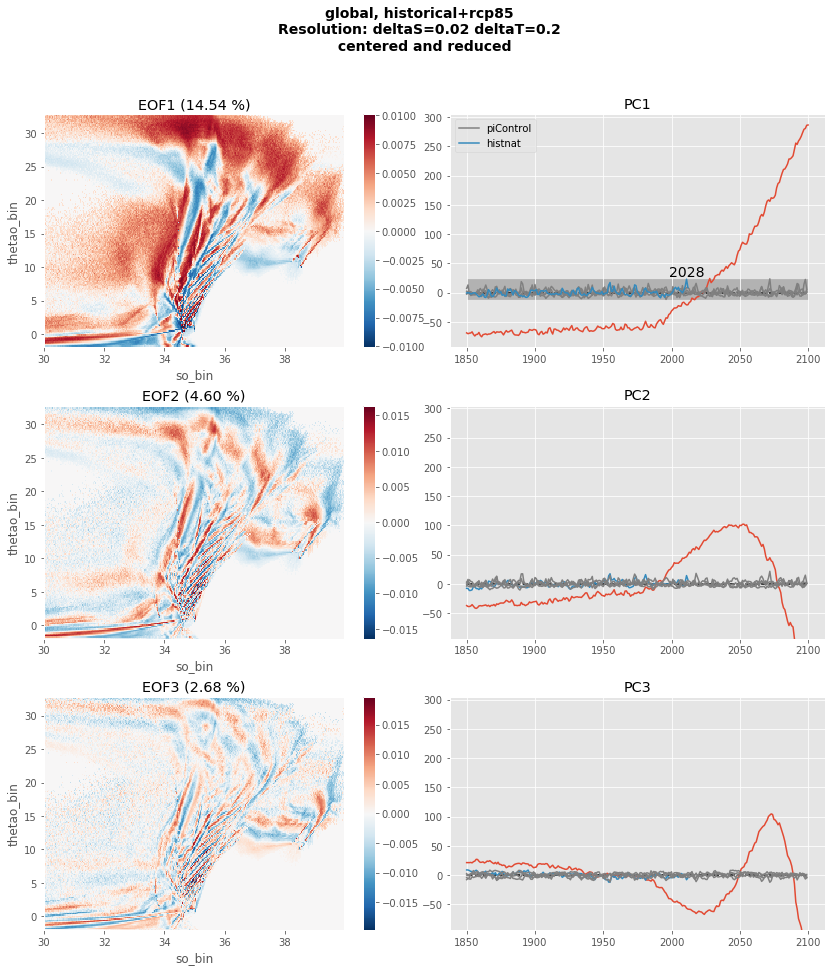

In [105]:
time=np.arange(1850,2101)
timehn = np.arange(1850,2013)
timepiC = np.arange(1850,2100)

fig,ax = plt.subplots(ncols=2,nrows=3,figsize=(14,15))

ymin = np.min(np.array([pseudo_pcs_piC1[:,0].min(),pseudo_pcs_piC2[:,0].min(),pseudo_pcs_piC3[:,0].min(),pseudo_pcs_piC4[:,0].min(),pseudo_pcs_hn[:,0].min()]))
ymax = np.max(np.array([pseudo_pcs_piC1[:,0].max(),pseudo_pcs_piC2[:,0].max(),pseudo_pcs_piC3[:,0].max(),pseudo_pcs_piC4[:,0].max(),pseudo_pcs_hn[:,0].max()]))

c = eofs_st_1.T.plot(ax=ax[0,0],add_colorbar=False)
cb = fig.colorbar(c,ax=ax[0,0],label='')
ax[0,0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1))+'%)')
ax[0,1].plot(time,pcs[:,0])
ax[0,1].plot(timepiC,pseudo_pcs_piC1[:,0],color='grey',label='piControl')
ax[0,1].plot(timepiC,pseudo_pcs_piC2[:,0],color='grey')
ax[0,1].plot(timepiC,pseudo_pcs_piC3[:,0],color='grey')
ax[0,1].plot(timepiC,pseudo_pcs_piC4[:,0],color='grey')
ax[0,1].plot(timehn,pseudo_pcs_hn[:,0],label='histnat')
ax[0,1].fill_between(x=time,y1=ymin,y2=ymax,alpha=0.5,color='grey',zorder=0)
ax[0,1].legend()
ax[0,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[0,1].set_title('PC1')
timeout = time[np.argmin(abs(pcs[:,0]-ymax)).data]
ax[0,1].text(timeout-30,ymax,str(timeout),fontsize=14,va='bottom')
ylim = ax[0,1].get_ylim()

c = eofs_st_2.T.plot(ax=ax[1,0],add_colorbar=False)
cb = fig.colorbar(c,ax=ax[1,0],label='')
ax[1,0].set_title('EOF2 ('+'%.2f '% Decimal(str(var2))+'%)')
ax[1,1].plot(time,pcs[:,1])
ax[1,1].plot(timehn,pseudo_pcs_hn[:,1])
ax[1,1].plot(timepiC,pseudo_pcs_piC1[:,1],color='grey')
ax[1,1].plot(timepiC,pseudo_pcs_piC2[:,1],color='grey')
ax[1,1].plot(timepiC,pseudo_pcs_piC3[:,1],color='grey')
ax[1,1].plot(timepiC,pseudo_pcs_piC4[:,1],color='grey')
ax[1,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1,1].set_title('PC2')
ax[1,1].set_ylim(ylim[0],ylim[1])

c = eofs_st_3.T.plot(ax=ax[2,0],add_colorbar=False)#,levels=levels,add_colorbar=False,extend='both')#vmax=vmax,center=0,cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[2,0],label='')
ax[2,0].set_title('EOF3 ('+'%.2f '% Decimal(str(var3))+'%)')
ax[2,1].plot(time,pcs[:,2])
ax[2,1].plot(timehn,pseudo_pcs_hn[:,2])
ax[2,1].plot(timepiC,pseudo_pcs_piC1[:,2],color='grey')
ax[2,1].plot(timepiC,pseudo_pcs_piC2[:,2],color='grey')
ax[2,1].plot(timepiC,pseudo_pcs_piC3[:,2],color='grey')
ax[2,1].plot(timepiC,pseudo_pcs_piC4[:,2],color='grey')
ax[2,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[2,1].set_title('PC3')
ax[2,1].set_ylim(ylim[0],ylim[1])

plt.subplots_adjust(hspace=0.25,wspace=0.08)
title = region+', historical+rcp85 \nResolution: deltaS='+str(deltaS)+' deltaT='+str(deltaT)+' \n centered and reduced'
plt.suptitle(title,fontsize=14,fontweight='bold')

# plt.savefig('acp_volumeTS_hnat_reduced_res_'+str(deltaS)+'_'+str(deltaT)+'_'+region+'.png') #002501 #0105

<xarray.DataArray 'pcs' ()>
array(178)
Coordinates:
    mode     int64 0

In [99]:
time[178]

2028